# **Method 03**: Teacher network and Student network for pose estimation using CSI data

## Part 1: Training YOLOv8 for Pose Estimation, Use YOLOv8 as Teacher network


In [ ]:
# Train YOLOv8
from ultralytics import YOLO

# Load the YOLOv8 pose model
model = YOLO('yolov8n-pose.pt')  # Choose the appropriate model size

# Train the model
model.train(data='data.yaml', imgsz=640, epochs=100, batch=32, device='cuda', workers=12, lr0=0.001, save_dir='d:\CSKU\NCU\workspace\method03')


In [7]:
# Evaluate on the validation set
metrics = model.val()

Ultralytics YOLOv8.2.78  Python-3.12.3 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,291,329 parameters, 0 gradients, 9.2 GFLOPs


val: Scanning D:\CSKU\NCU\workspace\dataset\method03\pose\val\labels\S01\A01.cache... 2559 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2559/2559 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [00:32<00:00,  4.90it/s]


                   all       2559       2559      0.999      0.994      0.991      0.987      0.942      0.927      0.936      0.639
                   A01        325        325      0.999          1      0.995      0.991      0.868      0.855      0.889      0.529
                   A02        332        332      0.999          1      0.995      0.995          1          1      0.995       0.69
                   A03        336        336      0.999          1      0.995      0.995          1          1      0.995      0.691
                   A04        347        347          1      0.999      0.995      0.995          1      0.997      0.995       0.69
                   A05        346        346      0.998          1      0.995      0.995          1          1      0.995      0.744
                   A06        316        316      0.999          1      0.995      0.995          1          1      0.995      0.736
                   A07        277        277          1      0.949   

In [43]:
# Save model 
# vault_path = '../method03/yolov8n-pose-for-csi.pt'
# model.save(vault_path)

YOLOv8 Result extract keypoint

In [2]:
from ultralytics import YOLO
kp_extractor = YOLO('yolov8n-pose-for-csi.pt')

In [3]:
#TODO: Do with our collected data

## Part 2: Using YOLOv8 Outputs with an LSTM Model in PyTorch

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from scipy.io import loadmat
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import re
import json

import cv2
import matplotlib.pyplot as plt

In [1]:
# Utility
# Sort file in natural order function
def natural_sort_key(s:str):
    """
    A sorting key function that sorts strings in human-natural order.

    Args:
        s (str): The input string to generate the sorting key for.

    Returns:
        list: A list where numeric parts of the string are converted to integers, 
              and non-numeric parts are converted to lowercase strings. 
              This allows for natural sorting of strings like "file1", "file10", "file2".
    
    Example:
        sorted(['file1', 'file10', 'file2'], key=natural_sort_key)
        # Output: ['file1', 'file2', 'file10']
    """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]


## Get CSI data

In [2]:
# We considered only amplitude data
# Load amplitude from csi data
def load_amplitude_data(mat_file_path):
    amplitude_list = []
    label_list = []
    # Load and sort CSI data files
    files = sorted(os.listdir(mat_file_path), key=natural_sort_key)
    
    # Filter for files excluding .dat and .txt
    pattern = r'.*\.(?!dat$|txt$)' 
    
    for file in files:
        if re.search(pattern, file):
            try:
                mat_data = loadmat(os.path.join(mat_file_path, file))
                label = os.path.join(mat_file_path, file).split('CSI\\')[-1].replace('.mat','.jpg')
                
                # Extract amplitude and phase
                amplitude = np.array(mat_data['amplitude']).reshape(-1,40).T # -1 means unknown dimension, simply explain is numpy will handle by multiply all list dimension 
                label_list.append(label)
                amplitude_list.append(amplitude)
            except (FileNotFoundError, OSError) as e:
                print(f"File error with {file}: {e}")
            except KeyError as e:
                print(f"Missing key 'amplitude' or 'phase' in {file}: {e}")
            except Exception as e:
                print(f"Unexpected error with {file}: {e}")

    return amplitude_list, label_list

def get_mat_files(root_dir):
    amplitude_list = []
    label_list = []
    for subject_dir in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject_dir)
        if not os.path.isdir(subject_path):
            continue
        for action_dir in os.listdir(subject_path):
            action_path = os.path.join(subject_path, action_dir)
            if not os.path.isdir(action_path):
                continue
            amplitude, label = load_amplitude_data(action_path)
            label_list.extend(label)
            amplitude_list.extend(amplitude)
    return amplitude_list, label_list

In [127]:
src = "../data/CSI/CSI"
amplitude_data_list, amplitude_label = get_mat_files(src)
amp_csi = np.array(amplitude_data_list)
amp_csi.shape

(16912, 40, 270)

Handling CSI data

In [128]:

# Flatten CSI data to 2D for normalization, then reshape back.
amp_csi_flat = amp_csi.reshape(-1, 270) # Shape: (16912*40, 270)
mean = np.mean(amp_csi_flat, axis=0)
std = np.std(amp_csi_flat, axis=0)
amp_csi_norm = (amp_csi_flat - mean) / std
amp_csi_norm = amp_csi_norm.reshape(16912, 40, 270)

## Get Keypoint data

FYI: In this section, I will use collected CS-student keypoint instead of our collected data. After test model performance I will adjust it.

In [152]:
# In this section, I will use collected CS-student keypoint
def get_pose(json_path):
    
    # Load the JSON file
    with open(json_path) as f:
        data = json.load(f)
        
    # Extract keypoints, bounding box and scores
    keypoints = data[0]['keypoints']
    bbox = data[0]['bbox']
    
    # return image keypoint and bbox values 
    return keypoints, bbox

In [153]:
keypoints = []
bboxes = []

pose_json_path = '../data/GT_Json/GT_Json'
csi_folder = '../data/CSI/CSI'


subjects = [subject for subject in os.listdir(csi_folder) if subject.startswith('S')]
for subject in subjects:
    subject_path = os.path.join(csi_folder, subject)
    actions = [a for a in os.listdir(subject_path) if os.path.isdir(os.path.join(subject_path, a))]
    for action in actions:
        action_path = os.path.join(subject_path, action)
        
        csi_files = sorted([f for f in os.listdir(action_path) if f.endswith('.mat')], key=natural_sort_key)
        # get keypoint and bbox values
        json_files = sorted([f for f in os.listdir(os.path.join(pose_json_path, subject, action)) if f.endswith('.json') and f.replace('.json', '.mat') in csi_files], key=natural_sort_key)
        
        for json_file in json_files:
            json_path = os.path.join(pose_json_path, subject, action, json_file)         
            keypoint, bbox = get_pose(json_path)  # Use the get_pose function to extract keypoints and bbox
            keypoints.append(keypoint)  # Append keypoints to the list
            bboxes.append(bbox)  # Append bbox to the list

In [154]:
keypoints = np.array(keypoints)
bboxes = np.array(bboxes)

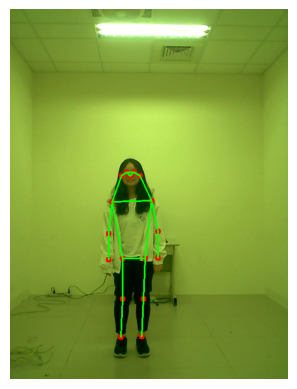

In [155]:
# Validate keypoint
# Function to draw keypoints on an image
def draw_keypoints(image_path, keypoints):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Draw keypoints
    for kp in keypoints:

        x, y = int(kp[0]), int(kp[1])  # Scale keypoints to image size
        cv2.circle(image, (x, y), 5, (255, 0, 0), -1)  # Draw a circle for each keypoint

    skeleton = [
        (0, 1), (0, 2), 
        (1, 2), (1, 3), 
        (2, 4),     
        (3, 5),                      
        (4, 6),                   
        (5, 6), (5, 7), (5, 11),     
        (6, 8), (6, 12),                       
        (7, 9),  
        (8, 10),
        (11, 12), (11, 13),
        (12, 14),   
        (13, 15),  
        (14, 16),]                  
  
    # Draw the skeleton by connecting keypoints
    for start, end in skeleton:
        start_point = (int(keypoints[start][0]), int(keypoints[start][1]))
        end_point = (int(keypoints[end][0]), int(keypoints[end][1]))
        cv2.line(image, start_point, end_point, (0, 255, 0), 2)  # Draw a line for each connection
    
    # Display the image with keypoints
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage
image_path = '../dataset/method03/pose/train/images/S01/A01/frame1.jpg'
draw_keypoints(image_path, keypoints[0])  # Draw keypoints for the first sample

Handling keypoints data

In [156]:
# Normalizing keypoint data
# get image size
tmp_img = '../dataset/method03/pose/train/images/S01/A01/frame1.jpg'
img = cv2.imread(tmp_img)

image_width = img.shape[1]  # Get the width of the image
image_height = img.shape[0]  # Get the height of the image

keypoints_norm = keypoints
keypoints_norm[:, :, 0] /= image_width   # Normalize x coordinates
keypoints_norm[:, :, 1] /= image_height  # Normalize y coordinates

# flatten keypoint for output
keypoints_flat = keypoints_norm.reshape(16912, -1)  # Shape: (16912, 34)


## Custom Pytorch Dataset

In [129]:
class CSIDataset(Dataset):
    def __init__(self, df):
        self.csi_data = df['amplitudes']
        self.keypoints = df['keypoints']
        print(f"Length of csi_data: {len(self.csi_data)}")
        print(f"Length of keypoints: {len(self.keypoints)}")
        
    def __len__(self):
        return len(self.csi_data)
    
    def __getitem__(self, idx):
        csi_sequence = self.csi_data[idx]
        keypoint = self.keypoints[idx]
        keypoint = keypoint.flatten()
        return torch.tensor(csi_sequence, dtype=torch.float32), torch.tensor(keypoint, dtype=torch.float32)

In [157]:
# data already synchorized
df = pd.DataFrame({'label':amplitude_label, 'amplitudes':tuple(amp_csi_norm), 'keypoints':tuple(keypoints_flat)})

In [159]:
amp_csi_norm.shape, keypoints_flat.shape

((16912, 40, 270), (16912, 34))

In [160]:
dataset = CSIDataset(df)

# Split the dataset
train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



Length of csi_data: 16912
Length of keypoints: 16912


## LSTM Model

In [161]:
class PoseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PoseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x: [batch_size, sequence_length, input_size]
        out, _ = self.lstm(x) # out: [batch_size, seqeunce_length, hidden_size]
        out = out[:, -1, :] # Take the output from the last time step
        out = self.fc(out)
        return out

In [162]:
# Init the model
input_size = 270
hidden_size = 256
num_layers = 5
output_size = 34 # 17 keypoint * 2 coordinates (x, y)

device = torch.device("cuda")

model = PoseLSTM(input_size, hidden_size, num_layers, output_size)
model.to(device)


PoseLSTM(
  (lstm): LSTM(270, 256, num_layers=5, batch_first=True)
  (fc): Linear(in_features=256, out_features=34, bias=True)
)

## Training the LSTM model

In [163]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [164]:
num_epoch = 50

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epoch)):
    model.train()
    total_train_loss = 0
    for csi_batch, keypoints_batch in train_loader:
        csi_batch = csi_batch.cuda()
        keypoints_batch = keypoints_batch.cuda()
        
        # Forward pass
        outputs = model(csi_batch)
        
        # print(f"outputs shape: {outputs.shape}")
        # print(f"keypoints_batch shape: {keypoints_batch.shape}")
        
        # Compute loss
        train_loss = criterion(outputs, keypoints_batch)
        
        # Bachward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        total_train_loss += train_loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for csi_batch, keypoints_batch in val_loader:
            csi_batch = csi_batch.cuda()
            keypoints_batch = keypoints_batch.cuda()
            
            # Forward pass
            outputs = model(csi_batch)
            # Compute loss
            val_loss = criterion(outputs, keypoints_batch)
            
            total_val_loss += val_loss.item()
        
    avg_val_loss = total_val_loss / len(train_loader)
    val_losses.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epoch}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

  2%|▏         | 1/50 [00:12<09:49, 12.04s/it]

Epoch: 1/50, Train Loss: 0.006757, Val Loss: 0.000538


 22%|██▏       | 11/50 [02:02<07:09, 11.00s/it]

Epoch: 11/50, Train Loss: 0.000627, Val Loss: 0.000173


 42%|████▏     | 21/50 [03:55<05:42, 11.81s/it]

Epoch: 21/50, Train Loss: 0.000340, Val Loss: 0.000159


 62%|██████▏   | 31/50 [06:09<04:15, 13.44s/it]

Epoch: 31/50, Train Loss: 0.000274, Val Loss: 0.000089


 82%|████████▏ | 41/50 [08:12<01:54, 12.68s/it]

Epoch: 41/50, Train Loss: 0.000185, Val Loss: 0.000085


100%|██████████| 50/50 [09:53<00:00, 11.86s/it]


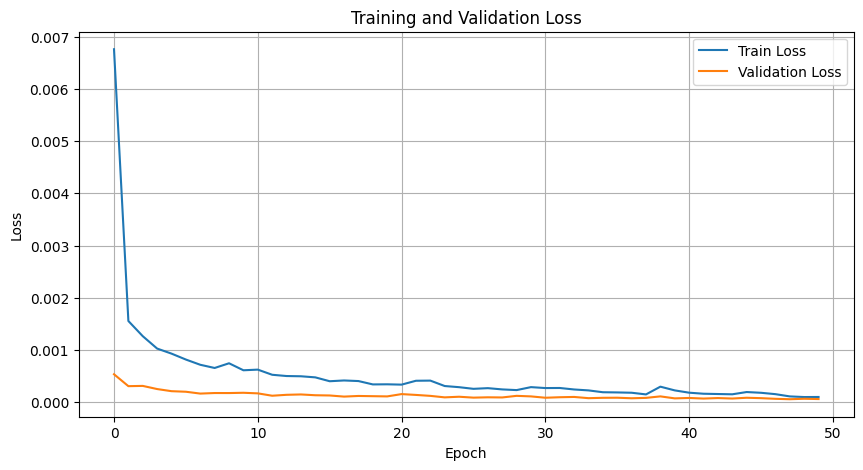

In [165]:
import matplotlib.pyplot as plt
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [19]:
# save model
# torch.save(model.state_dict(),'pose-lstm.pth')

# Result

In [166]:
import time
import torch

model.eval()

predicted_keypoints_list = []
true_keypoints_list = []
times = []
with torch.no_grad():
    for csi_batch, keypoints_batch in val_loader:
        csi_batch = csi_batch.cuda()
        keypoints_batch = keypoints_batch.cuda()
        start_time = time.time()
        outputs = model(csi_batch)
        end_time = time.time()
        predicted_keypoints = outputs.cpu().numpy()  # Shape: (batch_size, output_size)
        true_keypoints = keypoints_batch.cpu().numpy()
        
        inference_time = end_time - start_time
        
        predicted_keypoints_list.append(predicted_keypoints)
        true_keypoints_list.append(true_keypoints)
        times.append(inference_time)

predicted_keypoints_all = np.concatenate(predicted_keypoints_list, axis=0)  # Shape: (num_samples, output_size)
true_keypoints_all = np.concatenate(true_keypoints_list, axis=0)


In [167]:
max(times), min(times)

(0.029542207717895508, 0.00853109359741211)

In [168]:
image_width = 480  # Replace with your actual image width
image_height = 640  # Replace with your actual image height

# Denormalize predicted keypoints
predicted_keypoints_all_denorm = predicted_keypoints_all.copy()
predicted_keypoints_all_denorm[:, ::2] *= image_width   # x coordinates
predicted_keypoints_all_denorm[:, 1::2] *= image_height  # y coordinates

# Denormalize true keypoints (if you want to compare)
true_keypoints_all_denorm = true_keypoints_all.copy()
true_keypoints_all_denorm[:, ::2] *= image_width
true_keypoints_all_denorm[:, 1::2] *= image_height


Evaluation metric

In [350]:
# import numpy as np

# # Calculate PCK metric
# # TODO: Calculate each keypoint
# def calculate_pck(predicted, true, threshold=0.9):
#     # Assuming the keypoints are in the format (x1, y1, x2, y2, ..., xn, yn)
#     # Calculate the number of correct keypoints within the threshold
#     correct_keypoints = np.sum(np.sqrt((predicted[:, ::2] - true[:, ::2])**2 + (predicted[:, 1::2] - true[:, 1::2])**2) < threshold)
#     total_keypoints = predicted.shape[1] // 2  # Number of keypoints
#     pck = correct_keypoints / (len(predicted) * total_keypoints)  # PCK score
#     return pck

# # Calculate the PCK metric for the entire dataset
# pck_score = calculate_pck(predicted_keypoints_all_denorm, true_keypoints_all_denorm)

# # Print the PCK score
# print(f'PCK Score: {pck_score:.4f}')


PCK Score: 0.0392


In [169]:
# Define a Function to Visualize Skeleton
def visualize_keypoints_skeleton(keypoints, true_keypoints=None, image_path=None, save_dir=None):
    skeleton = [
        (0, 1), (0, 2), 
        (1, 2), (1, 3), 
        (2, 4),     
        (3, 5),                      
        (4, 6),                   
        (5, 6), (5, 7), (5, 11),     
        (6, 8), (6, 12),                       
        (7, 9),  
        (8, 10),
        (11, 12), (11, 13),
        (12, 14),   
        (13, 15),  
        (14, 16),]  
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Load and plot the image if image_path is provided
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    axes[0].imshow(image)
    axes[0].axis('off')
    
    # Plot predicted keypoints
    x_pred = keypoints[::2]
    y_pred = keypoints[1::2]
    if save_dir is None:
        print(f'Predicted: {x_pred}{y_pred}')
    ax_pred = axes[0]
    ax_pred.set_title('Predicted Keypoints')
    ax_pred.axis('equal')
    ax_pred.scatter(x_pred, y_pred, c='g')
    
    # Draw skeleton
    for joint_pair in skeleton:
        idx1, idx2 = joint_pair
        x_coords = [x_pred[idx1], x_pred[idx2]]
        y_coords = [y_pred[idx1], y_pred[idx2]]
        ax_pred.plot(x_coords, y_coords, c='g')

    # Optionally, plot true keypoints
    if true_keypoints is not None:
        x_true = true_keypoints[::2]
        y_true = true_keypoints[1::2]
        if save_dir is None:
            print(f'Ground truth: {x_true}{y_true}')
        ax_true = axes[1]
        ax_true.set_title('Ground Truth Keypoints')
        axes[1].imshow(image)
        ax_true.axis('equal')
        ax_true.axis('off')
        ax_true.scatter(x_true, y_true, c='b')
        
        for joint_pair in skeleton:
            idx1, idx2 = joint_pair
            x_coords = [x_true[idx1], x_true[idx2]]
            y_coords = [y_true[idx1], y_true[idx2]]
            ax_true.plot(x_coords, y_coords, c='b')

    plt.tight_layout()
    plt.axis('off')
    # plt.legend() 
    if save_dir is not None:
        # save in directory
        output_dir = save_dir  # Specify your output directory
        os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
        
        image_filename = os.path.join(output_dir, f'{image_path.split('\\')[1]}{image_path.split('\\')[2]}_{image_path.split('\\')[-1]}')
        plt.savefig(image_filename)  # Save the figure as a PNG file
        plt.close()  # Close the figure to free up memory
    else:
        plt.show()

Predicted: [185.28242 190.98027 178.07591 200.43967 169.36841 218.29948 155.50235
 231.44958 154.11328 236.26625 153.19965 217.50662 180.30647 237.0665
 188.51163 253.31831 200.13634][302.16513 295.90314 296.88055 300.8743  303.04062 338.3744  345.58496
 389.07556 401.45612 438.5457  454.56638 428.31628 434.87808 496.3047
 509.91455 570.45154 578.4319 ]
Ground truth: [183.97563 189.78404 178.16722 198.08177 168.20993 214.67725 153.27402
 228.78339 151.61447 241.22998 154.10379 216.33679 178.997   240.40022
 191.44359 272.76138 198.91154][303.81482 297.17664 297.17664 302.15527 302.98505 339.4951  346.96304
 390.11127 401.7281  435.74884 449.85498 422.47247 434.0893  475.57794
 508.76886 553.57666 577.6401 ]


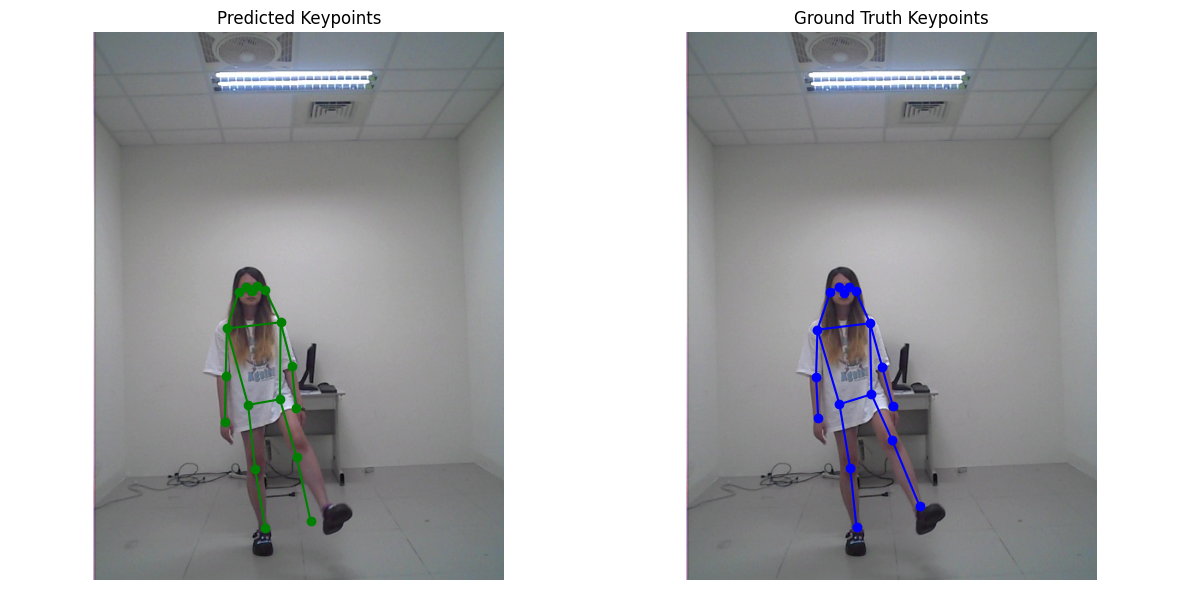

Predicted: [259.79858 266.0111  253.99393 274.55978 244.35945 288.25092 229.06007
 310.78613 205.72195 281.72452 230.93483 279.30908 241.10524 283.63205
 239.46188 286.3734  243.66522][267.19168 262.17004 261.85413 270.06827 268.4711  299.42984 294.06805
 250.52223 251.00491 214.77972 215.03674 395.07623 394.27777 482.84155
 482.1434  553.6468  553.96906]
Ground truth: [259.78018 266.2612  253.29918 273.66806 243.11475 286.63007 227.37515
 309.77652 205.15456 281.07492 232.00444 279.2232  240.33717 283.8525
 240.33717 286.63007 240.33717][267.1372  261.58206 261.58206 267.1372  267.1372  296.76465 296.76465
 251.39761 253.24933 218.99258 221.77014 395.83148 395.83148 484.71387
 485.6397  556.9308  557.8566 ]


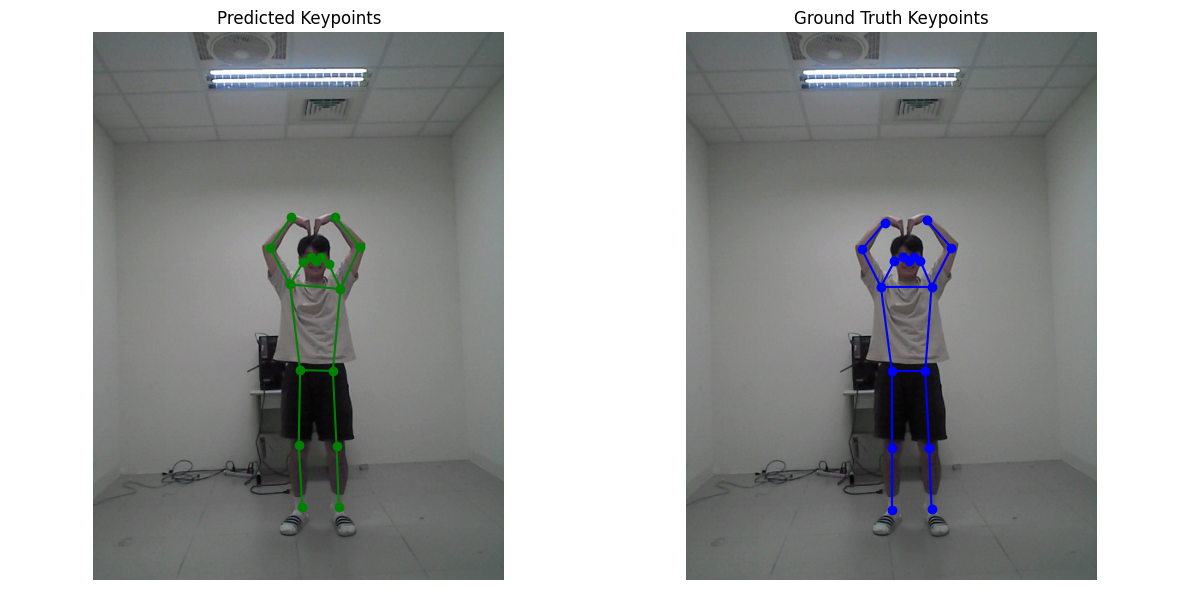

Predicted: [214.68369 220.12387 207.03766 223.12088 194.1756  232.51437 173.90112
 241.73846 156.7325  245.8233  143.6521  225.67125 187.49385 226.5932
 191.97934 220.98886 200.12042][270.96762 266.86548 264.68445 278.18173 273.96603 319.14313 308.27386
 363.87723 262.9809  403.1194  214.67398 424.16913 423.80478 505.7303
 505.66165 575.1388  573.0851 ]
Ground truth: [217.9891  223.43289 210.36778 224.52165 194.0364  232.14296 173.34999
 239.76428 154.8411  246.29683 141.77599 227.78793 188.59262 226.69917
 192.94765 221.25537 198.39145][271.44095 267.08594 264.90842 277.9735  273.61847 318.2576  308.45877
 362.8967  260.55338 396.64822 210.47046 427.13348 427.13348 508.79034
 509.87915 577.3822  578.47095]


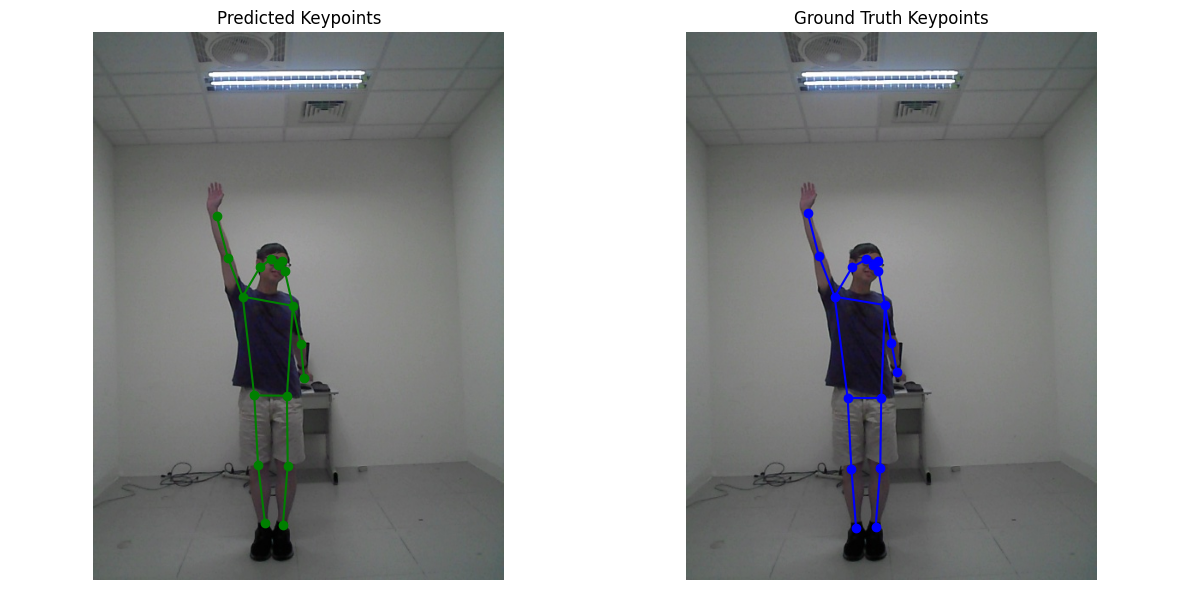

Predicted: [194.48032 200.65042 188.4717  212.01439 182.4831  231.43816 170.33878
 242.80423 138.20445 240.75793  96.77984 221.69281 186.13503 225.2257
 186.90244 222.06502 191.21518][296.4484  290.00183 290.55493 294.0925  295.8324  330.22736 334.44373
 384.222   369.21765 437.3627  402.85565 425.90656 427.21674 503.63763
 502.9276  573.5158  573.8281 ]
Ground truth: [194.22832 200.92174 188.37157 210.96188 181.67813 229.3688  169.12796
 239.40895 131.47743 240.24562  89.64351 221.8387  185.86153 221.00201
 189.20824 220.16534 191.71828][296.57114 289.87772 290.7144  294.8978  296.57114 331.71167 335.89502
 382.74902 365.17877 430.4397  390.2791  427.92966 429.603   503.2307
 504.06738 571.8383  572.67505]


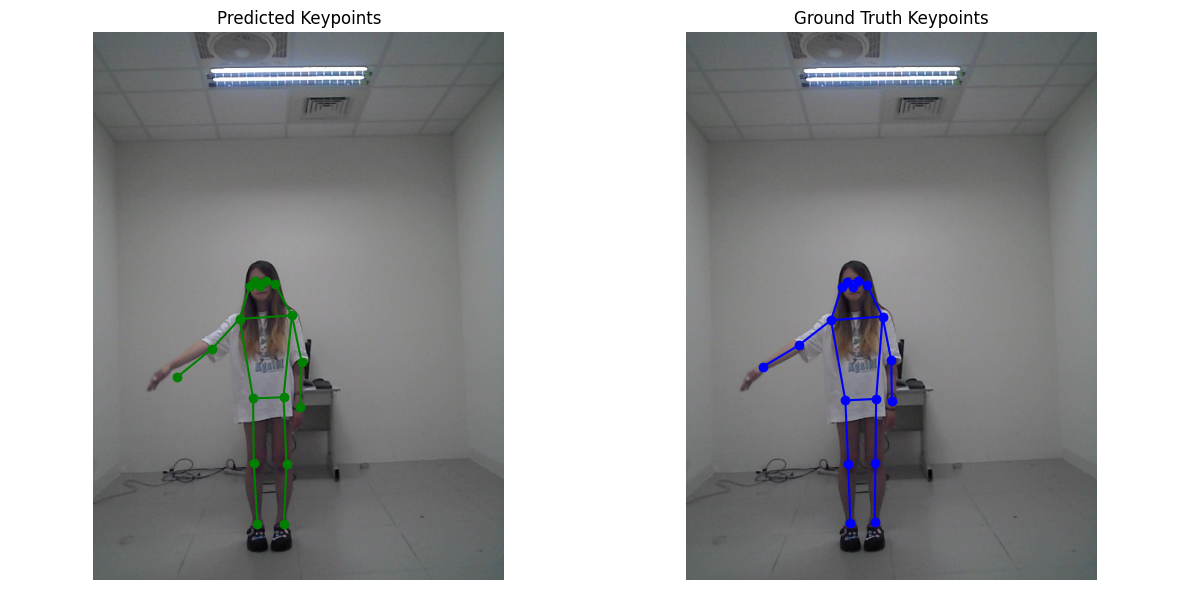

Predicted: [224.19153 231.43188 217.01247 241.45918 206.05807 257.63724 187.69386
 265.94983 175.78642 269.64627 168.76573 242.08545 200.17886 243.66852
 199.48138 242.05556 201.8278 ][247.51187 240.86496 241.55244 248.25201 248.55025 295.00067 292.9955
 351.773   349.39545 401.33502 400.48315 405.63992 404.77277 492.47278
 489.55594 570.00006 569.17456]
Ground truth: [224.58725 231.36778 216.83807 242.99158 207.1516  258.48993 188.74728
 263.33316 174.21758 269.14505 173.24893 245.89749 204.24565 247.8348
 203.27701 246.86613 201.3397 ][245.81348 239.03293 240.00159 246.7821  247.75078 296.18317 291.3399
 353.33337 347.52148 401.76575 395.95386 407.57764 407.57764 490.88135
 491.84998 570.3104  571.2791 ]


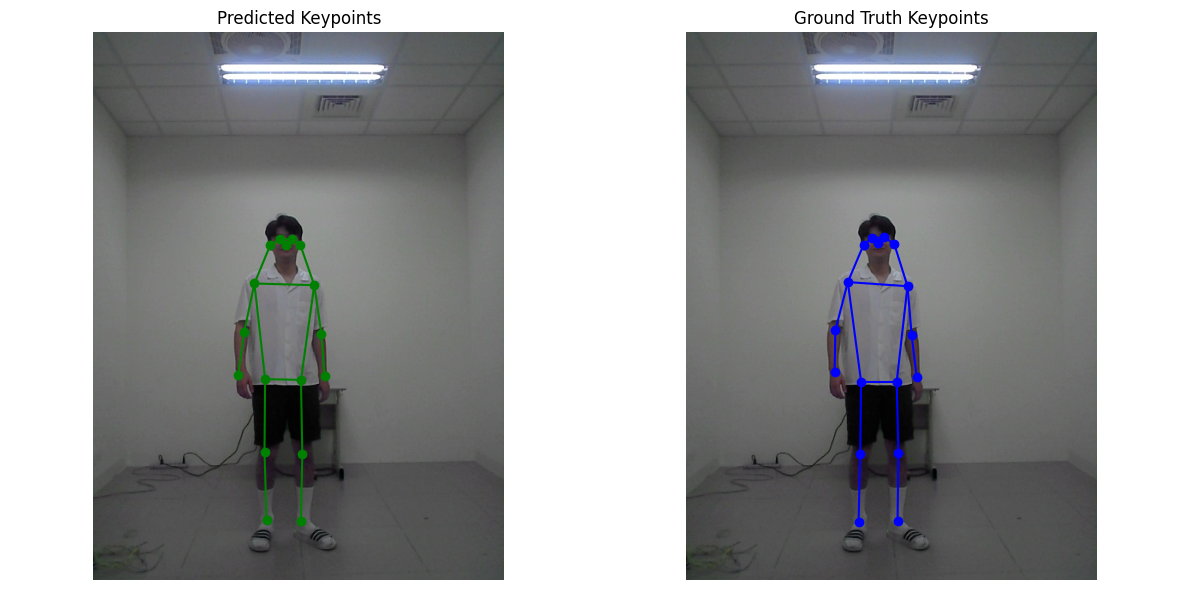

Predicted: [222.32559 227.8639  213.13126 234.65701 199.44919 252.89899 181.99957
 283.13864 171.34273 268.8607  166.77914 242.1747  198.01443 244.8982
 201.36322 243.8801  205.52238][237.60983 231.15218 232.15213 241.24342 242.92067 275.52722 290.84827
 214.15239 353.5335  151.03467 410.20367 403.44113 404.68994 498.90427
 495.2214  582.7859  582.84436]
Ground truth: [224.43529 229.46713 215.62956 235.75694 200.53403 253.3684  180.40666
 291.1072  169.08502 286.07538 167.82706 240.78879 196.76015 243.30472
 201.79199 244.56267 204.30792][237.47821 231.18839 231.18839 239.99413 239.99413 273.95908 289.0546
 222.38268 349.4367  158.22667 403.52902 404.787   406.04495 500.392
 497.8761  583.4174  584.67535]


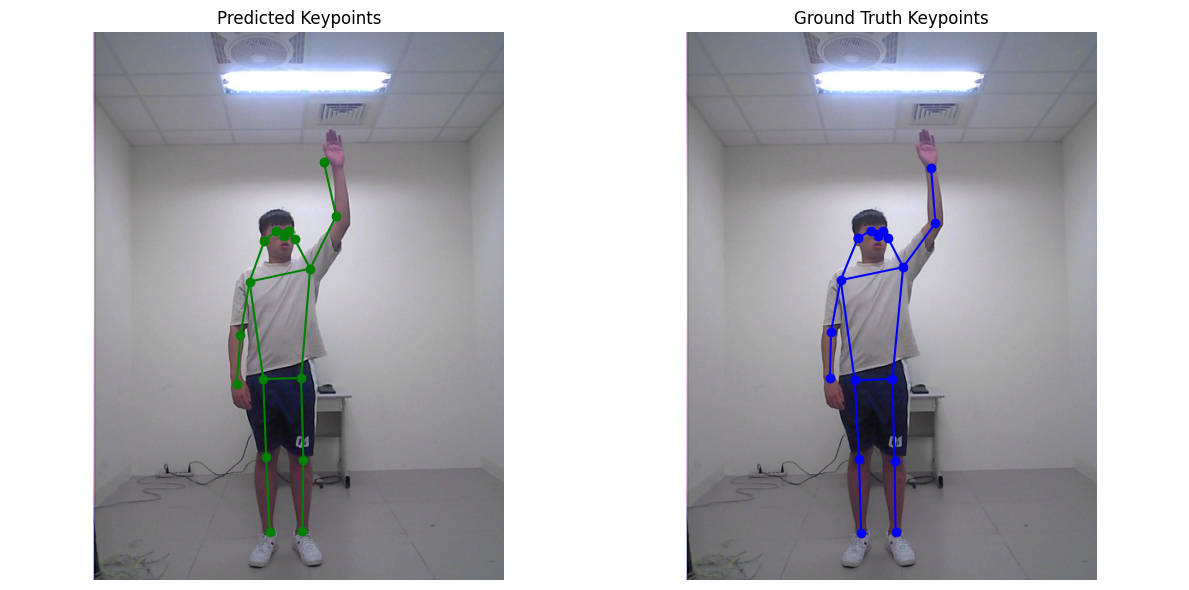

Predicted: [206.22685 212.95744 200.84431 224.33582 194.39717 239.21234 184.91263
 250.95671 169.78528 251.03586 157.71649 232.59041 196.40005 232.29459
 193.74524 231.29749 194.51398][296.36392 290.58844 291.5334  297.06967 298.37823 331.4691  332.21652
 344.16217 346.58356 346.14197 343.44498 426.7423  426.7897  502.7508
 501.5428  570.4599  571.3459 ]
Ground truth: [207.29881 213.95824 201.47182 225.61224 194.81238 238.93109 186.4881
 251.41751 171.50438 249.75269 166.50981 230.60681 193.97995 229.77438
 193.14752 231.43924 193.14752][296.30185 290.47485 290.47485 295.46942 296.30185 329.599   329.599
 342.91785 345.41516 344.58276 334.59357 426.16074 426.99316 502.74417
 502.74417 569.33844 571.0033 ]


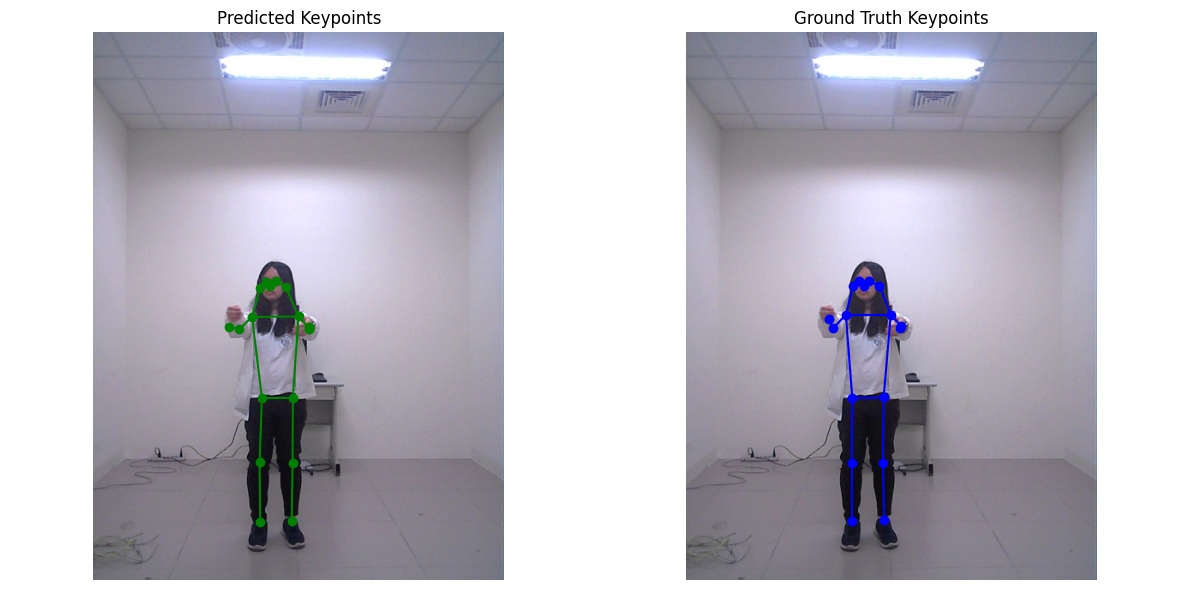

Predicted: [275.04028 281.3087  267.33084 292.26202 257.98367 314.27417 249.17358
 331.60306 241.74832 330.39435 245.27687 307.70255 268.04877 314.0718
 262.6334  315.8123  272.42163][331.9151  323.97858 325.85324 325.20718 329.87885 358.4152  361.54175
 412.2496  415.66208 459.88217 463.31815 423.9357  423.8601  486.83014
 483.25763 543.8296  543.74365]
Ground truth: [301.95447 306.62552 293.39084 312.85358 277.82065 328.42377 259.91495
 343.99396 244.34476 354.8931  244.34476 310.51807 270.03555 312.85358
 270.8141  312.85358 270.8141 ][295.18872 287.40363 288.18213 290.51767 290.51767 323.99356 322.43655
 372.26117 374.59668 418.1932  425.97833 404.95856 405.73706 470.35336
 473.4674  543.53326 544.31177]


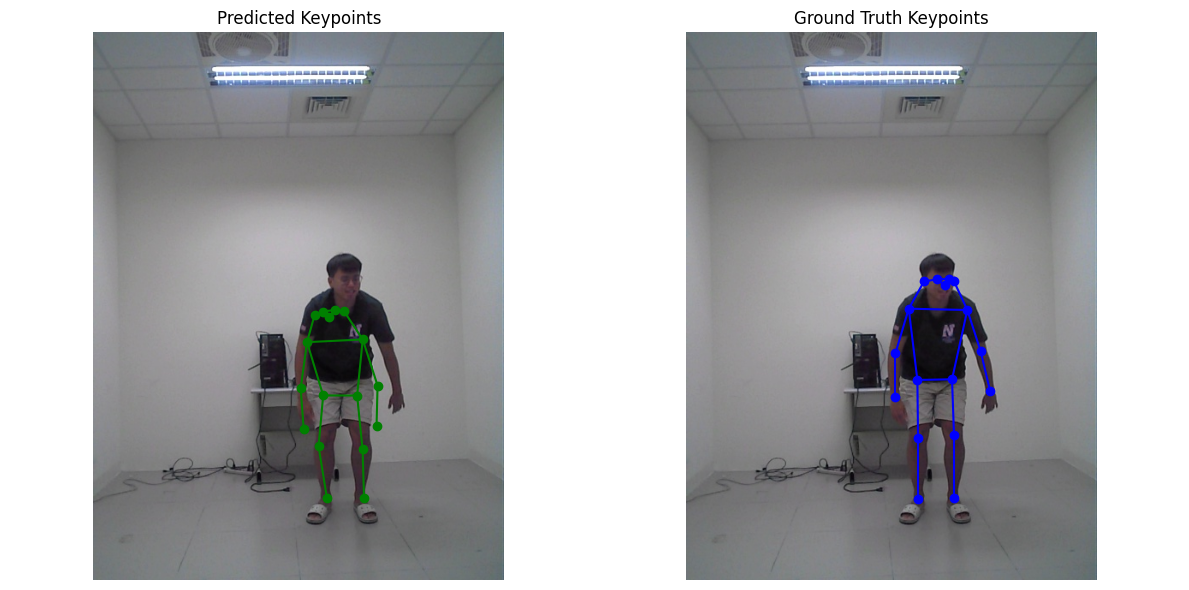

Predicted: [251.98657 258.67734 245.117   268.8497  237.22382 290.69608 223.69907
 332.3767  194.07683 347.14334 161.8868  279.82977 238.80138 283.68695
 238.64781 287.91498 242.49416][258.86826 252.93922 254.08517 260.64954 262.8908  295.86337 303.94128
 294.1963  337.8637  275.60126 358.59006 397.4986  397.62933 480.18762
 478.99426 554.90765 555.30426]
Ground truth: [259.8173  266.38663 253.24797 274.83295 242.92471 290.78705 222.2782
 330.2031  187.55455 325.5107  175.35434 277.64838 236.35536 282.34076
 239.17079 287.03314 241.04773][256.47714 250.84627 250.84627 258.3541  256.47714 295.8932  300.58557
 281.81604 337.18622 235.83063 381.29462 399.1257  399.1257  478.89624
 481.7117  554.91296 556.7899 ]


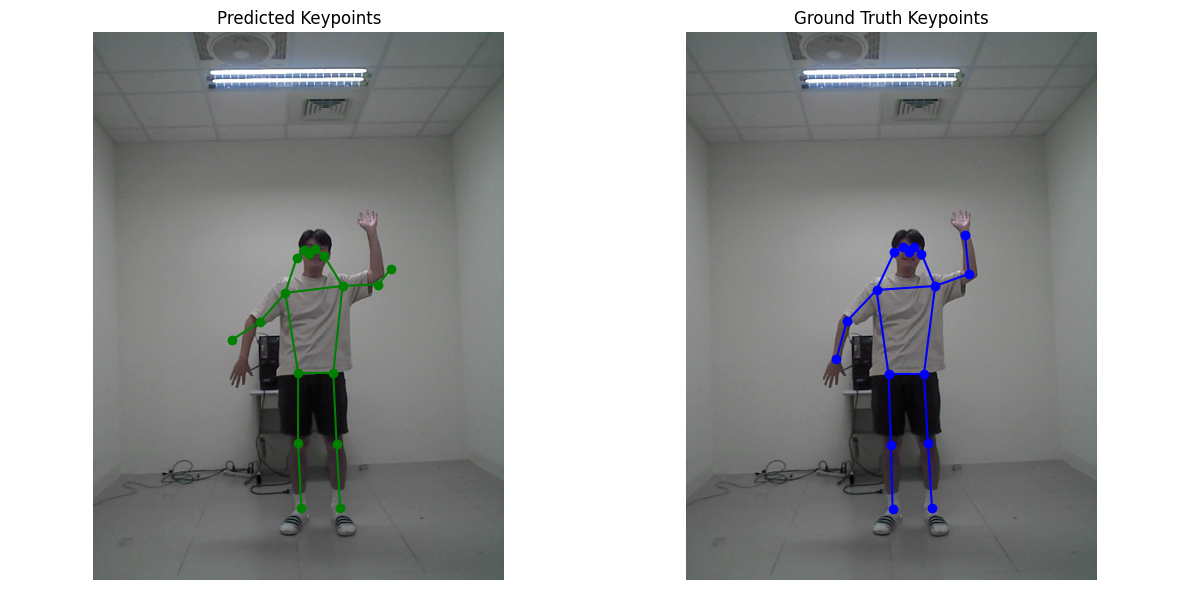

Predicted: [160.64276 168.71048 160.5985  195.02577 172.38486 207.03502 183.7123
 215.42682 191.15738 178.47552 168.10489 189.78722 166.84283 174.49117
 141.97437 215.40787 154.44614][273.997   266.51898 265.69757 264.41675 266.82272 310.1305  307.93204
 371.55164 368.38995 408.77182 406.9607  429.3026  423.13965 497.16446
 480.5557  562.8739  552.7227 ]
Ground truth: [168.96588 176.28897 168.05049 199.1736  168.05049 208.32745 171.71204
 231.2121  178.11974 200.08899 154.31972 195.51205 169.88127 193.68129
 176.28897 262.3352  194.59668][261.35287 254.94519 254.94519 257.69135 259.5221  303.4606  304.37598
 360.2145  357.46832 408.72992 386.76068 417.8838  416.9684  496.60693
 497.52234 547.8685  569.83777]


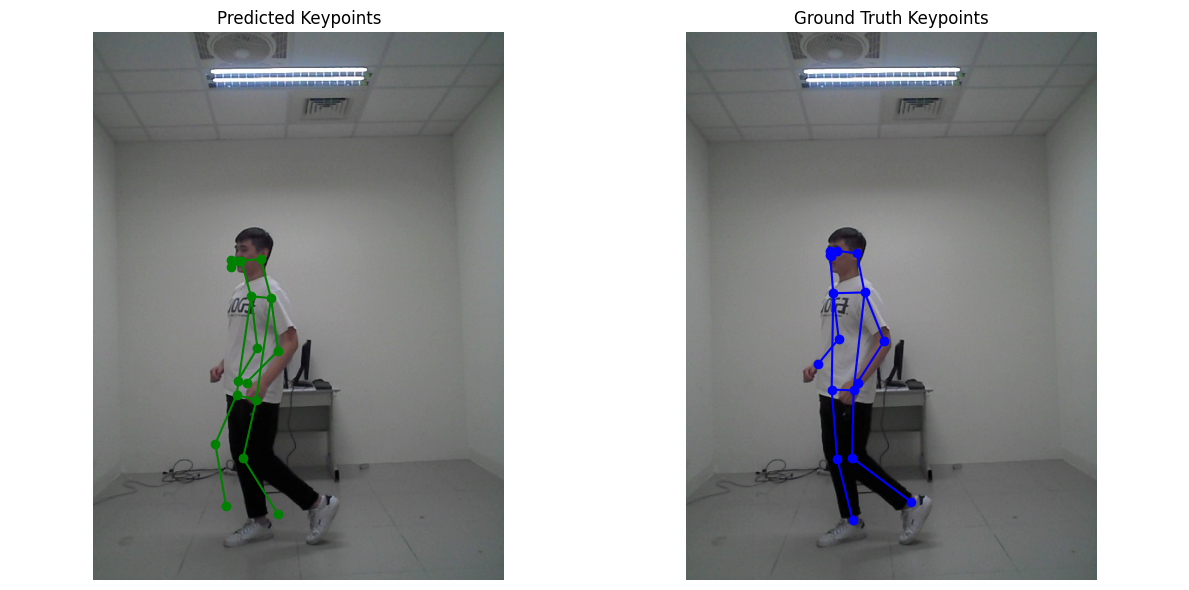

In [170]:
# Visualize for Each Sample
image_dir = '../data/Video/Video'
for idx in range(10):
    image_path = os.path.join(image_dir, df['label'][val_indices].iloc[idx])
    predicted_kp = predicted_keypoints_all_denorm[idx]
    true_kp = true_keypoints_all_denorm[idx]
    visualize_keypoints_skeleton(predicted_kp, true_keypoints=true_kp, image_path=image_path)